In [1]:
import requests
from tqdm import tqdm
import time

# 카카오 API

- 키워드로 장소 검색: https://developers.kakao.com/docs/latest/ko/local/dev-guide#search-by-keyword
- 카카오 개발자 API 키 발급: https://developers.kakao.com/
  - App 생성
  - REST API 키 복사, 붙여넣기

In [4]:
app_key = 'KakaoAK ' + 'cc5520cf408d03a425e50ce23d9c02bd'

url = 'https://dapi.kakao.com/v2/local/search/keyword.json'

params = {
    'query': '치킨',
    'category_group_code': 'FD6', # 음식점
    'page': 45
}

headers = {
    'Authorization': app_key
}

res = requests.get(url, params=params, headers=headers).json()

print(res.keys())

dict_keys(['documents', 'meta'])


In [5]:
res['documents']

[{'address_name': '경기 고양시 덕양구 용두동 432-46',
  'category_group_code': 'FD6',
  'category_group_name': '음식점',
  'category_name': '음식점 > 치킨',
  'distance': '',
  'id': '17126860',
  'phone': '02-382-1117',
  'place_name': '원조카우보이 한방통닭',
  'place_url': 'http://place.map.kakao.com/17126860',
  'road_address_name': '경기 고양시 덕양구 용두로47번길 191',
  'x': '126.8950350447584',
  'y': '37.62644849863467'},
 {'address_name': '부산 금정구 장전동 146-2',
  'category_group_code': 'FD6',
  'category_group_name': '음식점',
  'category_name': '음식점 > 치킨',
  'distance': '',
  'id': '8860320',
  'phone': '051-514-3885',
  'place_name': '뉴숯불통닭 본점',
  'place_url': 'http://place.map.kakao.com/8860320',
  'road_address_name': '부산 금정구 금강로335번길 55',
  'x': '129.0834297751688',
  'y': '35.23775776866604'},
 {'address_name': '부산 수영구 광안동 120-101',
  'category_group_code': 'FD6',
  'category_group_name': '음식점',
  'category_name': '음식점 > 치킨',
  'distance': '',
  'id': '445457740',
  'phone': '051-754-9233',
  'place_name': '낭만장작 누룽지통

In [6]:
res['meta']

{'is_end': True,
 'pageable_count': 45,
 'same_name': {'keyword': '치킨', 'region': [], 'selected_region': ''},
 'total_count': 55028}

# 한계
- 45페이지까지의 값밖에 받아올 수 없음

In [7]:
params = {
    'query': '치킨',
    'page': 46
}

res = requests.get(url, params=params, headers=headers).json()

print(res)

{'errorType': 'InvalidArgument', 'message': 'page is more than max'}


# TinyDB

In [9]:
pip install tinydb

Note: you may need to restart the kernel to use updated packages.


In [10]:
from tinydb import TinyDB, Query

db = TinyDB('db.json')

# 분할 검색

- 우리나라 지도를 위경도 0.25 단위의 작은 사각형으로 쪼개어 검색
- 상세페이지에서 가격 긁어오기 https://place.map.kakao.com/main/v/9847579
- IP 차단 피하기 위해 5초 대기
- DB 저장
  - place_name: 음식점 이름
  - menu: 메뉴 이름
  - price: 가격

In [11]:
start_x = 126 # 126.0 - 130.0
start_y = 33 # 33.0 - 39.0

dx = 0.25
dy = 0.25

for i in tqdm(range(18)):
    for j in range(26):
        x = start_x + dx * i
        y = start_y + dy * j
        print(x, y)

        for page in range(1, 46):
            params = {
                'query': '치킨',
                'page': page,
                'rect': f'{x},{y},{x + dx},{y + dy}'
            }

            res = requests.get(url, params=params, headers=headers).json()
            
            if len(res['documents']) == 0:
                break

            for doc in res['documents']:
                place_name = doc['place_name']

                detail_url = f'https://place.map.kakao.com/main/v/{doc["id"]}'

                data = requests.get(detail_url, headers=headers).json()

                if 'menuInfo' not in data:
                    continue

                menu_list = data['menuInfo']['menuList']

                for menu_item in menu_list:
                    price = 0
                    if 'price' in menu_item:
                        price = int(menu_item['price'].replace(',', ''))

                    db.insert({
                        'place_name': place_name,
                        'menu': menu_item['menu'],
                        'price': price
                    })
                
                time.sleep(5)

            if res['meta']['is_end']:
                break

  0%|          | 0/18 [00:00<?, ?it/s]126.0 33.0
126.0 33.25
  0%|          | 0/18 [00:53<?, ?it/s]


KeyboardInterrupt: 

# 저장된 결과 확인

In [12]:
db

<TinyDB tables=['_default'], tables_count=1, default_table_documents_count=56248, all_tables_documents_count=['_default=56248']>

# 35000원 초과하는 메뉴 검색

In [13]:
db.search(Query().price > 35000)

[{'place_name': '돌담너머바다 판포점', 'menu': '돔베 스테이크', 'price': 39000},
 {'place_name': '마담나탈리소셜클럽', 'menu': '글렌피딕 15Y', 'price': 250000},
 {'place_name': '인판포', 'menu': '바베큐 플레이터', 'price': 60000},
 {'place_name': '인판포', 'menu': '마라소라새우', 'price': 40000},
 {'place_name': '제마닭', 'menu': '닭도리탕(대)', 'price': 36000},
 {'place_name': '제마닭', 'menu': '꽃도리탕(중)', 'price': 38000},
 {'place_name': '제마닭', 'menu': '꽃도리탕(대)', 'price': 48000},
 {'place_name': '먹고정', 'menu': '백돼지한근반', 'price': 63000},
 {'place_name': '먹고정', 'menu': '백돼지한근', 'price': 42000},
 {'place_name': '먹고정', 'menu': '흑돼지한근반', 'price': 80000},
 {'place_name': '먹고정', 'menu': '흑돼지한근', 'price': 54000},
 {'place_name': '모루쿠다', 'menu': '모루쿠다 육합', 'price': 40000},
 {'place_name': '원조장수통닭', 'menu': '토종닭', 'price': 60000},
 {'place_name': '원조장수통닭', 'menu': '오리주물럭', 'price': 60000},
 {'place_name': '진솔통닭', 'menu': '토종닭(1마리)', 'price': 60000},
 {'place_name': '진솔통닭', 'menu': '오리(1마리)', 'price': 60000},
 {'place_name': '오름지미정원', 'menu': '찹스테이크 (3

# 35000 초과 AND "치" 포함

In [14]:
db.search((Query().price > 35000) & (Query().menu.search('치')))

[{'place_name': '화덕에꾸운닭 전남담양점', 'menu': '랍스터 치킨', 'price': 38000},
 {'place_name': '아웃닭 신촌역점', 'menu': '오리지날 레드핀 양념치킨', 'price': 187000},
 {'place_name': '누구나홀딱반한닭 홍대점', 'menu': '바사칸치빵파티', 'price': 36900},
 {'place_name': '크치치킨 경희대점', 'menu': '치킨세트D', 'price': 37000},
 {'place_name': '누구나홀딱반한닭 선릉점', 'menu': '바사칸치빵파티', 'price': 38900},
 {'place_name': '화덕에꾸운닭 강원홍천점', 'menu': '랍스터 치킨', 'price': 38000},
 {'place_name': '화덕에꾸운닭 창원진동점', 'menu': '랍스터 치킨', 'price': 38000},
 {'place_name': '앗싸마늘닭 본점', 'menu': '앗싸 스페셜 두마리 치찜세트', 'price': 37900}]

# 전국 치킨 평균 가격

- 프랜차이즈를 모두 포함하여 정확한 가격은 아님

In [15]:
chickens = db.search(Query().menu.search('치'))

prices = []

for chicken in chickens:
    prices.append(chicken['price'])
    
avg_price = sum(prices) / len(prices)

print('치킨 %d개의 평균 가격은 %.2f원 입니다' % (len(chickens), avg_price))

치킨 22703개의 평균 가격은 17763.68원 입니다


# 가격 분포 그래프

In [17]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas>=0.23 in c:\users\qqq96\appdata\local\programs\python\python38\lib\site-packages (from seaborn) (1.2.1)



<AxesSubplot:ylabel='Count'>

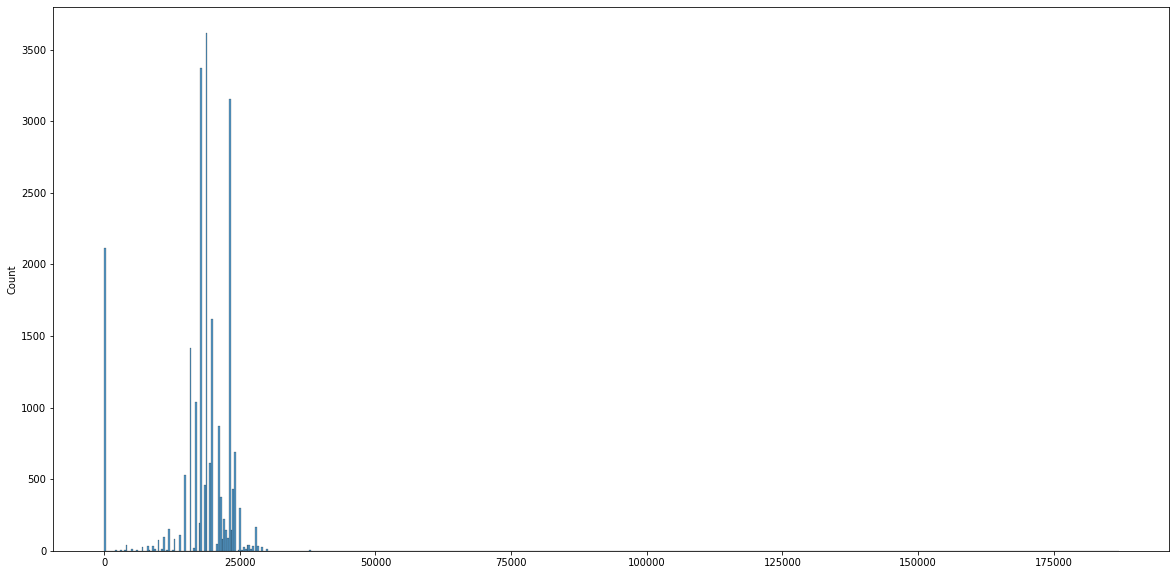

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x=prices, ax=ax)